# Nuclear Instrumentation Health Monitoring System
## Notebook 01: Data Exploration

### Dataset: Combined Cycle Power Plant (CCPP)
Source: UCI Machine Learning Repository  
9,568 hourly observations collected over 6 years from a Combined Cycle Power Plant.

| Variable | Description | Unit |
|----------|-------------|------|
| AT | Ambient Temperature | °C |
| V | Exhaust Vacuum | cm Hg |
| AP | Ambient Pressure | millibar |
| RH | Relative Humidity | % |
| PE | Net Electrical Output (target) | MW |

**Note:** AT, V, AP, and RH are treated as sensor signals for health monitoring.
PE is the plant output variable and is not used as a monitored sensor in this analysis.

### Dataset Selection Rationale

A combined cycle power plant dataset was chosen because real nuclear plant 
sensor data is proprietary and not publicly available. The Combined Cycle 
Power Plant dataset from the UCI Machine Learning Repository was selected 
as the closest publicly available analog — it shares the same sensor types 
and physical relationships found in nuclear plant instrumentation (temperature, 
pressure, vacuum, humidity). The methodology implemented in this project is 
identical to what would be applied in a nuclear context.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset 
# AT: Ambient Temperature (°C)
# V: Exhaust Vacuum (cm Hg)
# AP: Ambient Pressure (millibar)
# RH: Relative Humidity (%)
# PE: Net Electrical Output (MW) - target variable, not monitored as sensor
df = pd.read_excel('../data/Folds5x2_pp.xlsx')

# First look
print(df.shape)
print(df.head(10))
print(df.describe())

(9568, 5)
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
5  26.27  59.44  1012.23  58.77  443.67
6  15.89  43.96  1014.02  75.24  467.35
7   9.48  44.71  1019.12  66.43  478.42
8  14.64  45.00  1021.78  41.25  475.98
9  11.74  43.56  1015.14  70.72  477.50
                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.83

In [3]:
# Coefficient of Variation for each sensor
# CV = (std/mean) * 100
# Measures variability relative to the mean, allowing for comparison across sensors

cv = (df[['AT', 'V', 'AP', 'RH']].std() / df[['AT', 'V', 'AP', 'RH']].mean()) * 100
print("Coefficient of Variation (%):")
print(cv.round(2))

Coefficient of Variation (%):
AT    37.92
V     23.40
AP     0.59
RH    19.92
dtype: float64


## Exploratory Data Analysis

### Sensor Signal Distributions

Before applying any statistical methods, we examine the distribution of each 
sensor signal. This serves two purposes:

1. **Sanity checking** — do the value ranges make physical sense?
2. **Normality assessment** — SPRT assumes that sensor residuals follow a normal 
distribution. If the raw signals are heavily skewed or multimodal, we need to 
be aware of this before modeling.

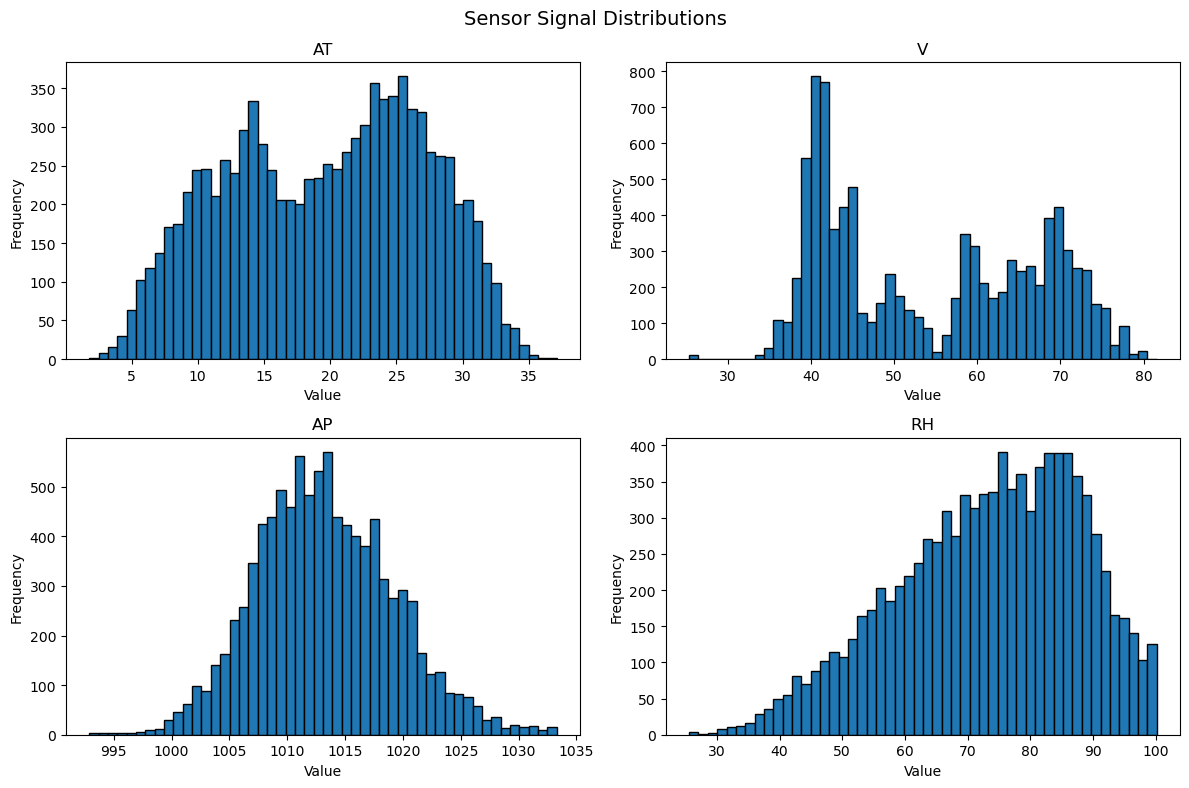

In [6]:
# Distribution of each sensor variable
# Helps identify skewness, outliers, and non-normality
# Important for validating SPRT's normality assumption
fig, axes = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Sensor Signal Distributions', fontsize=14)

sensors = ['AT', 'V', 'AP', 'RH']

# bins=50 chosen to balance resolution against noise in the distribution
# edgecolor added for visual clarity across dense bins
for ax, sensor in zip(axes.flatten(), sensors):
    ax.hist(df[sensor], bins=50, edgecolor='black')
    ax.set_title(sensor)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Observations

AT: The ambient temperature sensor displays a distribution characterized by 'two-humps'. This is known as a bimodal distribution - a probability distribution with two distinct peaks (local maxima) separated by a lower frequency area, often called a valley. This makes sense because the ambient temperature surrounding a power plant should reflect seasonal patterns. Cooler months cluster around one peak, warmer months around another. So we can rule out the possibility of this bimodal shape being due to random noise. It's important to note that we cannot treat our AT readings as a normal distribution. This means we cannot apply SPRT directly to raw AT readings — we must first remove the expected signal and work with residuals, which should be 
approximately normally distributed.

V: The exhaust vacuum also displays a bimodal distribution. However, this distribution appears more choppy than what we see with AT and has larger, more sudden fluctuations. Comparing the AT and V distributions, we should note that both higher vacuum pressures and the frequency of their occurence appear to correlate with the frequency of higher ambient temperatures. This makes physical sense since the cooling medium used to condense the steam within the condenser will rise with the ambient temperature, making the condensing process less efficient and forcing the steam temperature to rise, leading to higher vacuum pressures. Similarly, the lower vacuum pressures and their frequency correlates to the frequency and value of lower ambient temperatures, since the condensing process is more efficient at these ambient temperatures.

AP: The ambient pressure sensor displays an almost normal distribution. This is supported by the fact that atmospheric pressure varies relatively smoothly and symmetrically around a mean.

RH: Humidity tends to cluster at higher values with a long tail toward drier conditions. This also makes physical sense seasonally and geographically.